In [1]:
import javalang
import json
import re
import time
import random
import nltk
nltk.download('punkt')
import numpy as np
import pickle
import tensorflow as tf
#tf.enable_eager_execution() 
import os
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/yurong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Function declaration

In [2]:
'''
Function：
    Input the code token list, comment string，and return whether it's invalid
The rule of valid method:
    1. code token size <= 100
    2. One-sentence-comment（I hope model generate only one sentence.
       If training data consist multi-sentence comment, the effect will be bad and the first sentence only can not
       properly describe the functionality of the method）

PS: I regard "tester", "setter", "getter" and "constructor" as valid method
'''
def is_invalid_method(token_len, nl):   
    if token_len > 100:
        return True
    if len(nl.split('.')) != 1 or len(nltk.word_tokenize(nl)) > 30:
        return True
    else :
        return False


    
    
'''
Function: 
    Input the root of AST and the deep of the tree, 
    it will filter the null value and return the list of SBT (structural-based travesal) and print the tree structure
'''
def parse_tree(root, deep):

    seq = []
    seq.extend(['(', str(root).split('(')[0]])
    #print('\t'*(deep)+str(root).split('(')[0])    # show node name
    for attr in root.attrs:
        if eval('root.%s' % attr) in [None, [], "", set(), False]:    # filter the null attr
            continue
        elif isinstance(eval('root.%s' % attr), list):
            x = eval('root.%s' % attr)
            if not all(elem in x for elem in [None, [], "", set(), False]):    # if not all elements in list are null
                seq.extend(['(',attr])
                #print('\t'*(deep+1)+attr)
                #deep += 1
                for i in eval('root.%s' % attr):    # recursive the list
                    if i is None or isinstance(i, str):    # perhaps it has None value in the list
                        continue
                    #deep += 1
                    seq.extend(parse_tree(i, deep))
                    
                    #deep -= 1
                #deep -= 1
                seq.extend([')',attr])
        elif 'tree' in str(type(eval('root.%s' % attr))):    #if the attr is one kind of Node, recursive the Node
            seq.extend(['(',attr])
            #print('\t'*(deep+1)+attr)
            #deep += 2
            seq.extend(parse_tree(eval('root.%s' % attr), deep))
            #deep -= 2
            seq.extend([')',attr])
        else:
            seq.extend(['(','<'+str(attr)+'>_'+str(eval('root.%s' % attr)),')','<'+str(attr)+'>_'+str(eval('root.%s' % attr))])
            #exec("print('\t'*(deep+1)+attr+': '+str(root.%s))" % attr)    #it must be normal attribute
    seq.extend([')', str(root).split('(')[0]])
    return seq




'''
Function:
    1. "camelCase" -> ["camel", "Case"]
    2. "under_score" -> ["under", "_", "score"]
    3. "normal" -> ["normal"]
'''
def split_identifier(id_token):
    if  "_" in id_token:
        return id_token.split("_")
    elif id_token != id_token.lower() and id_token != id_token.upper():
        matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', id_token)
        return [m.group(0) for m in matches]
    else:
        return [id_token]

    
    
'''
Function:
    1. input the list of train, test, valid dataset
    2. filter the dataset, split it to train, test, valid set and save as the smaller dataset.
    3. return the amount of the data from smaller datasets.
Example:
    filter_dataset(['./data/train.json', './data/test.json', './data/valid.json'], './data')
Note:
    The filter method is different from the method in DeepCom, because I have no idea how DeepCom did.
    It doesn't make sense that DeepCom could filter so many data via the method mentioned in its paper.
'''
def filter_dataset(path_list, save_path):
    
    inputs = []
    for path in path_list:
        input_file = open(path)
        inputs.extend(input_file.readlines())
        input_file.close()
    outputs = []
    output_train_file = open(save_path+'/filter_train.json', "w")
    output_test_file = open(save_path+'/filter_test.json', "w")
    output_valid_file = open(save_path+'/filter_valid.json', "w")
    
    print('Original total: '+str(len(inputs)))
    for pair in inputs:
        pair = json.loads(pair)
        tokens_parse = javalang.tokenizer.tokenize(pair['code'])
        if is_invalid_method(len(list(tokens_parse)), pair['nl']):
            continue
        outputs.append(json.dumps(pair))

    random.shuffle(outputs)
    print('Final total: '+str(len(outputs)))
    print('Data shuffle complete')
    train_index = int(len(outputs)*0.8)
    test_index = int(len(outputs)*0.9)
    train_output = outputs[:train_index]
    test_output = outputs[train_index+1:test_index]
    valid_output = outputs[test_index+1:]
    
    for row in train_output:
        output_train_file.write(row+'\n')
    output_train_file.close()
    print('filter train data finish writing')
    for row in test_output:
        output_test_file.write(row+'\n')
    output_test_file.close()
    print('filter test data finish writing')
    for row in valid_output:
        output_valid_file.write(row+'\n')
    print('filter valid data finish writing')
    output_valid_file.close()

    return len(train_output), len(test_output), len(valid_output)


'''
Parameters:
    path: the path of the data you want to read
    code_voc: code vocabulary, the data type is list
    comment_voc: comment vocabulary, the data type is list
Return values:
    code_tokens, comment_tokens: 2-dimension list, store the code and comment into list, snippet by snippet
    code_voc, comment_voc: the all vocabularies in the file of the path, data type is list
Note:
    It hasn't used SBT in DeepCom.
TODO:
    Change the rare words in comments into other common words via pre-trained embedding
'''
def readdata(path, code_voc, comment_voc):
    input_file = open(path)
    inputs = input_file.readlines()

    code_tokens = []          # code_tokens = ['<START>', '<Modifier>', 'public', '<Identifier>',....]
    comment_tokens = []       # comment_tokens = []

    start = time.time()
    for index, pair in enumerate(inputs):
        if index%5000 == 0 and index != 0:
            print(index)
        pair = json.loads(pair)
        # =============== extract the code part of the snippet =========================
        
        #TODO: 以下寫成另一個function，切token的部分
        tokens_parse = javalang.tokenizer.tokenize(pair['code'])
        tokens = []
        for token in tokens_parse:    # iterate the tokens of the sentence
            token = str(token).split(' ')
            splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and under_score
            temp = ['<'+token[0]+'>']    # token[0] is token type, token[1] is token value
            temp.extend(splitted_id)
            tokens.extend(temp)
            for x in tokens:
                if x not in code_voc:
                    code_voc.append(x)
        tokens.insert(0, '<START>')
        tokens.append('<END>')
        code_tokens.append(tokens)
        
        #=============== extract comment part of the snippet ==========================
        tokens = nltk.word_tokenize(pair['nl'])
        comment_tokens.append(tokens)
        for x in tokens:
            if x not in comment_voc:
                comment_voc.append(x)

    print('readdata:')
    print('\tdata amount: '+str(len(code_tokens)))
    print('\trun time: '+str(time.time()-start))

    input_file.close()
    return code_tokens, comment_tokens, code_voc, comment_voc


'''
Usage:
    Transform the token to the index in vocabulary
    ['<START>', '<Modifier>', 'public', ..., '<Separator>', ';', '<Separator>', '}', '<END>']
    => [0, 7, 8, ..., 14, 29, 14, 30, 1]
Parameter data type: 
    2-dimension list
Return data type:
    2-dimension list
'''
def token2index(lst, voc):
    for index, seq in enumerate(lst):
        seq_index = []
        for token in seq:
            seq_index.append(voc.index(token))
        lst[index] = seq_index
    return lst


'''
Parameters:
    lst: the list of sequences to be padded
    pad_data: the value you want to pad
Return type:
    numpy array
'''
def pad_sequences(lst, pad_data):
    maxlen = max(len(x) for x in lst)
    for index, seq in enumerate(lst):
        lst[index].extend([pad_data] * (maxlen-len(seq)))
    return np.array(lst)

'''
Parameters:
    x: the list of data
    batch_sz: batch size
Return shape:
    [None, batch_sz, None]
Example:
    a = [1,2,3,4,5,6,7,8,9,10]
    a = getBatch(x=a, batch_sz=3)
    a
    ---output---
    [[1,2,3], [4,5,6], [7,8,9]]
'''
def getBatch(x, batch_sz):
    dataset = []
    while(len(x)>=batch_sz):
        dataset.append(x[:batch_sz])
        x = x[batch_sz:]
    if type(x) == np.ndarray:
        return np.array(dataset)
    elif type(x) == list:
        return dataset

## Prune the original big dataset into simpler and better dataset
* #### Size of training set, testing set and valid set ->  (81932, 10241, 10241)
* #### If you already have "filter_train.json", "filter_test.json" and "filter_valid.json", then you can skip this code cell.

In [7]:
filter_dataset(['./data/train.json', './data/test.json', './data/valid.json'], './filter_dataset')


Original total: 588108
Final total: 101220
Data shuffle complete
filter train data finish writing
filter test data finish writing
filter valid data finish writing


(80976, 10121, 10121)

## Reading training data (it costs about 40 mins)
* #### If you already have 'train_data.pkl', you can skip this code cell below and directly read 'train_data.pkl'

In [8]:
code_voc = ['<PAD>','<START>','<END>','<UNK>']
comment_voc = ['<PAD>','<START>','<END>','<UNK>']
code_train, comment_train, code_voc, comment_voc = readdata('./filter_dataset/filter_train.json', code_voc, comment_voc)
#code_test, comment_test, code_voc, comment_voc = readdata('./filter_dataset/filter_test.json', code_voc, comment_voc)
code_train = token2index(code_train, code_voc)
comment_train = token2index(comment_train, comment_voc)
code_train = pad_sequences(code_train, code_voc.index('<PAD>'))
comment_train = pad_sequences(comment_train, comment_voc.index('<PAD>'))
print('size of code vocabulary: ', len(code_voc))
print('size of comment vocabulary: ', len(comment_voc))

# Saving the training data:
with open('train_data.pkl', 'wb') as f:
    pickle.dump([code_train, comment_train, code_voc, comment_voc], f)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
readdata:
	data amount: 80976
	run time: 2230.783646583557
size of code vocabulary:  42152
size of comment vocabulary:  29404


In [3]:
# Getting back the training data:
with open('train_data.pkl', 'rb') as f:
    code_train, comment_train, code_voc, comment_voc = pickle.load(f)
    
print('size of code vocabulary: ', len(code_voc))
print('size of comment vocabulary: ', len(comment_voc))

size of code vocabulary:  42152
size of comment vocabulary:  29404


## Just test the functionality of transforming source code to SBT

In [ ]:
input_file = open('./data/test.json')
inputs = input_file.readlines()
pair = json.loads(inputs[0])
tree = javalang.parse.parse('class aa {'+pair['code']+'}')
print(pair['code'], end='\n')

_, node = list(tree)[2]    # 前兩個用來篩掉class aa{ }的部分
seq = parse_tree(node, 0)
for i in seq:
    print(i,end='')


In [4]:
BUFFER_SIZE = len(code_train)
BATCH_SIZE = 32
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 512
units = 512
vocab_inp_size = len(code_voc)
vocab_tar_size = len(comment_voc)

In [5]:
max_length_inp = max(len(t) for t in code_train)
max_length_targ = max(len(t) for t in comment_train)

In [6]:
def lstm(units):
    return tf.keras.layers.LSTM(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [7]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = lstm(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x, initial_state = hidden)        
        return output, state_h, state_c
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))

In [8]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = lstm(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden[1], 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state_h, state_c, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units)), tf.zeros((self.batch_sz, self.dec_units))

In [9]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.optimizers.Adam()  #tensorflow 2.0
#optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [10]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
lossArray = np.array([])

In [ ]:
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden_h, hidden_c = encoder.initialize_hidden_state()
    
    hidden = [hidden_h, hidden_c]
    
    total_loss = 0
    

    code_train_batch = getBatch(code_train, BATCH_SIZE)
    
    comment_train_batch = getBatch(comment_train, BATCH_SIZE)
    
    dataset = [(code_train_batch[i], comment_train_batch[i]) for i in range(0, len(code_train_batch))]
    
    np.random.shuffle(dataset)

    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden_h, enc_hidden_c = encoder(inp, hidden)
            
            dec_hidden = [enc_hidden_h, enc_hidden_c]
            
            dec_input = tf.expand_dims([comment_voc.index('<START>')] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden_h, dec_hidden_c, _ = decoder(dec_input, dec_hidden, enc_output)
                
                dec_hidden = [dec_hidden_h, dec_hidden_c]
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 200 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    lossArray = np.append(lossArray, (total_loss / N_BATCH) )
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.0110
Epoch 1 Batch 200 Loss 0.0231
Epoch 2 Batch 800 Loss 0.0281
Epoch 2 Batch 1000 Loss 0.0286
Epoch 2 Batch 1200 Loss 0.0282
Epoch 2 Batch 1400 Loss 0.0332
Epoch 2 Batch 1600 Loss 0.0460
Epoch 2 Batch 1800 Loss 0.0339
Epoch 2 Batch 2000 Loss 0.0425
Epoch 2 Batch 2200 Loss 0.0197
Epoch 2 Batch 2400 Loss 0.0549
Epoch 2 Loss 0.0300
Time taken for 1 epoch 2323.9259016513824 sec

Epoch 3 Batch 0 Loss 0.0202
Epoch 3 Batch 200 Loss 0.0246
Epoch 3 Batch 400 Loss 0.0083
Epoch 3 Batch 600 Loss 0.0446
Epoch 3 Batch 800 Loss 0.0155
Epoch 3 Batch 1000 Loss 0.0460
Epoch 3 Batch 1200 Loss 0.0248
Epoch 3 Batch 1400 Loss 0.0317
Epoch 3 Batch 1600 Loss 0.0219
Epoch 3 Batch 1800 Loss 0.0455
Epoch 3 Batch 2000 Loss 0.0189
Epoch 3 Batch 2200 Loss 0.0506
Epoch 3 Batch 2400 Loss 0.0384
Epoch 3 Loss 0.0283
Time taken for 1 epoch 2320.6367814540863 sec

Epoch 4 Batch 0 Loss 0.0348
Epoch 4 Batch 200 Loss 0.0179
Epoch 4 Batch 400 Loss 0.0090
Epoch 4 Batch 600 Loss 0.0386
Epoch 4 Batch 80

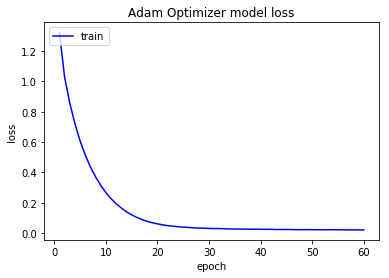

In [29]:
plt.plot(range(1, EPOCHs+1), lossArray, "b", label="train")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Adam Optimizer model loss")
plt.legend(loc = 2)
plt.show()

In [58]:
# TODO: 必須解決test set有可能有<UNK>，不然沒辦法translate test set
def evaluate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    tokens_parse = javalang.tokenizer.tokenize(code)
    inputs = []
    for token in tokens_parse:    # iterate the tokens of the sentence
        token = str(token).split(' ')
        splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and under_score
        temp = ['<'+token[0]+'>']    # token[0] is token type, token[1] is token value
        temp.extend(splitted_id)
        inputs.extend(temp)

    inputs.insert(0, '<START>')
    inputs.append('<END>')
    inputs += ['<PAD>'] * (max_length_inp - len(inputs))
    for index, token in enumerate(inputs):
        inputs[index] = code_voc.index(token)
    inputs = np.array(inputs)
    inputs = tf.expand_dims(inputs, 0)
    
    result = ''

    
    hidden_h, hidden_c = tf.zeros((1, units)), tf.zeros((1, units))
    
    hidden = [hidden_h, hidden_c]

    enc_output, enc_hidden_h, enc_hidden_c = encoder(inputs, hidden)
    dec_hidden = [enc_hidden_h, enc_hidden_c]
    dec_input = tf.expand_dims([comment_voc.index('<START>')], 1)       
    

    for t in range(max_length_targ):
        predictions, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, dec_hidden, enc_output)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += comment_voc[predicted_id] + ' '

        if comment_voc[predicted_id] == '<END>':
            return result, code, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, code, attention_plot

In [59]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [67]:
def translate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ):
    result, code, attention_plot = evaluate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(code))
    print('Predicted translation: {}'.format(result))
    
    print(type(attention_plot))
    #attention_plot = attention_plot[:len(result.split(' ')), :len(code.split(' '))]
    #plot_attention(attention_plot, code.split(' '), result.split(' '))

In [54]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [68]:
f = open('./filter_dataset/filter_train.json')
inputs = f.readlines()
f.close()
test_inputs = []
test_outputs = []
for pair in inputs[:20]:
    pair = json.loads(pair)
    test_inputs.append(pair['code'])
    test_outputs.append(pair['nl'])

In [69]:
#print(test_inputs[7])
test_outputs[14]

'Creates a share intent'

In [70]:
translate(test_inputs[14], encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ)

Input: private static Intent createShareIntent(Context context,final String shareText){
  final Intent shareIntent=new Intent(Intent.ACTION_SEND);
  shareIntent.putExtra(android.content.Intent.EXTRA_SUBJECT,context.getString(R.string.share_subject));
  shareIntent.putExtra(android.content.Intent.EXTRA_TEXT,shareText);
  shareIntent.setType("text/plain");
  return shareIntent;
}

Predicted translation: a new protocol is useful for no matches a new protocol is useful for no matches a new protocol is useful for no matches a new protocol is useful for 
<class 'numpy.ndarray'>
